# Wasserstein GAN with Gradient Penalty
## For generation of features based on LHCO2020 datasets

In [1]:
import h5py as h5
import numpy as np
from math import ceil, floor
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

Using TensorFlow backend.


2.1.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
filenames = {
    "herwig": "Herwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]
features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]
 # Can be flexibly changed to suit GAN needs

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    output_frame["mj1-mj2"] = output_frame["mj1"] -output_frame["mj2"]

    return output_frame

In [4]:
# Network hyperparameters

BATCH_SIZE = 1024# Uses about 3 GB of VRAM for batch size of 512
EPOCHS = 1000
LEARNING_RATE = 0.00001
N_CRITIC = 5
C_LAMBDA = 0.5

In [5]:
df = load_data("herwig")
df["tau2j2"]=np.where(df["tau2j2"]==0, 0.000001, df["tau2j2"]) 
min(df["tau2j2"])

D:\Users\Azure\anaconda3\envs\GPU\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


1e-06

In [6]:
df = load_data("herwig")
df.dropna(inplace = True)
#df["tau2j2"]=np.where(df["tau2j2"]==0, 0.000001, df["tau2j2"]) 
# Ensures all batches have same size

df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)

df.reset_index(drop = True, inplace = True)
df = df.astype('float32')

In [7]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,...,ej1,ej2,ejj,pjj,mjj,tau21j1,tau32j1,tau21j2,tau32j2,mj1-mj2
0,-606.640015,136.223999,-2463.290039,115.829002,41.708900,19.615000,16.282600,1410.239990,-311.454010,516.468018,...,2543.183594,1537.945679,4081.129395,840.942322,3993.548828,0.470283,0.830110,0.614313,0.647716,2.881004
1,1075.790039,560.247986,-473.667999,253.820999,98.636002,46.423801,37.188900,-785.905029,-476.933990,-1670.449951,...,1326.645630,1906.993530,3233.639160,312.914948,3218.463379,0.470658,0.801074,0.345675,0.681456,220.523193
2,-963.197998,-802.231995,-255.048004,369.252991,203.923996,32.369499,22.955299,1066.229980,662.479980,-1211.520020,...,1331.436768,1748.691895,3080.128662,222.883026,3072.053955,0.158733,0.709165,0.349252,0.687567,249.183990
3,-914.739014,-1285.349976,-390.425995,420.726013,183.169006,29.843300,24.244101,910.085022,1286.180054,228.893997,...,1678.783691,1593.454956,3272.238770,4.799760,3272.235107,0.162928,0.812380,0.515532,0.832525,355.978119
4,1178.770020,-442.437988,-816.497009,429.519989,272.453003,162.826004,113.084999,-945.479004,402.459015,-412.460999,...,1560.898804,1110.571655,2671.470459,240.044449,2660.664062,0.597630,0.694514,0.720654,0.639655,343.837708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999419,-710.262024,-1026.920044,-1307.729980,796.106995,744.283020,368.661987,210.828003,692.814026,976.697998,-41.325802,...,1975.596313,1198.612427,3174.208740,73.136452,3173.365967,0.495325,0.571873,0.770408,0.594857,763.957764
999420,-268.907990,1307.540039,1420.180054,333.614014,240.792007,171.697006,130.660995,155.938995,-1274.060059,-1473.140015,...,1977.418091,1957.884277,3935.302490,122.490051,3933.395508,0.713051,0.760998,0.298112,0.729554,208.620010
999421,314.462006,1388.619995,-158.914001,420.259003,295.635986,57.412300,44.277100,65.702904,-1444.400024,-1056.260010,...,1492.991333,1792.290039,3285.281494,388.263031,3262.257812,0.194199,0.771213,0.600804,0.573244,342.734100
999422,-133.639999,1522.699951,-229.511993,632.781006,504.207001,105.698997,48.149700,29.203501,-1470.739990,-839.638977,...,1670.198242,1704.347900,3374.546143,127.697525,3372.129150,0.209634,0.455536,0.705832,0.759785,443.363007


In [8]:
np.any(np.isnan(df))

False

In [9]:
df = df.drop(df.columns[[0,1,2,4,5,6,7,8,9,11,12,13,14,15,16,17,20,22]], axis=1)

In [10]:
df

,mj1,mj2,mjj,tau21j1,tau21j2,mj1-mj2
0,115.829002,112.947998,3993.548828,0.470283,0.614313,2.881004
1,253.820999,33.297798,3218.463379,0.470658,0.345675,220.523193
2,369.252991,120.069000,3072.053955,0.158733,0.349252,249.183990
3,420.726013,64.747902,3272.235107,0.162928,0.515532,355.978119
4,429.519989,85.682297,2660.664062,0.597630,0.720654,343.837708
...,...,...,...,...,...,...
999419,796.106995,32.149200,3173.365967,0.495325,0.770408,763.957764
999420,333.614014,124.994003,3933.395508,0.713051,0.298112,208.620010
999421,420.259003,77.524902,3262.257812,0.194199,0.600804,342.734100
999422,632.781006,189.417999,3372.129150,0.209634,0.705832,443.363007


In [11]:
# Normalize all inputs between -1 and 1

train_features = ["mj1-mj2"]
scaler = MinMaxScaler((-1,1)).fit(df[train_features])
feature_df = scaler.transform(df[train_features])

X_train, X_test = train_test_split(feature_df, test_size = 0.25)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))
gc.collect()

Dataset consists of 732 batches of 1024 samples each, total 749568 samples
Testset consists of 244 batches of 1024 samples each, total 249856 samples


20

In [12]:
X_train

array([[-0.7866008 ],
       [-0.70541036],
       [-0.98151016],
       ...,
       [-0.97094136],
       [-0.87603074],
       [-0.85690117]], dtype=float32)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [14]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(len(train_features), activation='tanh'))
    assert model.output_shape == (None, len(train_features))

    return model

In [15]:
generator = make_generator_model()

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1)) # WGAN: No sigmoid activation in last layer

    return model

In [17]:
discriminator = make_discriminator_model()

In [18]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [19]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [20]:
@tf.function
def gradient_penalty(real, fake, epsilon): 
    # mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [21]:
@tf.function
def discriminator_loss(real_output, fake_output, gradient_penalty):
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + C_LAMBDA * gradient_penalty
    return loss

In [22]:
@tf.function
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

In [23]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

In [24]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [25]:
@tf.function
def train_step_generator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [26]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [27]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [28]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

    return disc_loss

In [29]:
def graph_gan(generator):
    fakedata = scaler.inverse_transform(generator(tf.random.normal((10000, len(train_features))), training=False))
    plt.ylabel("Normalized to Unity")
    
    plt.hist(df['mj1-mj2'], bins = 50, range = (0, 800), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(fakedata, bins = 50, range = (0, 800), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()
    

In [30]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [31]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [32]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [33]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    
    print_losses = ((epoch + 1) % 10 == 0)
    draw_outputs = ((epoch + 1) % 100 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0


    # Training

    for image_batch in dataset:
      train_gen_loss += K_eval(train_step_generator(image_batch))
      for n in range(n_critic):
        train_disc_loss += K_eval(train_step_discriminator(image_batch))
    
    train_gen_losses.append(train_gen_loss / len_dataset)
    train_disc_losses.append(train_disc_loss / len_dataset / n_critic)

            
    # Evaluation

    for test_batch in testset:
      test_gen_loss += K_eval(evaluate_generator())
      test_disc_loss += K_eval(evaluate_discriminator(test_batch))

    test_gen_losses.append(test_gen_loss / len_testset)
    test_disc_losses.append(test_disc_loss / len_testset)

    # Logging

    if print_losses:
      print()

      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)

      graph_genloss()
      graph_discloss()


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

  1%|▊                                                                             | 10/1000 [03:40<6:24:28, 23.30s/it]


Epoch 10:

Generator training loss: -1.2999445618501777
Discriminator training loss: 0.10510613682878311

Generator validation loss: -1.7930186879439431
Discriminator validation loss: 0.14025898012103605


  2%|█▌                                                                            | 20/1000 [07:38<6:28:13, 23.77s/it]


Epoch 20:

Generator training loss: -1.886477389947964
Discriminator training loss: 0.14814420585505297

Generator validation loss: -2.229786419477619
Discriminator validation loss: 0.19880020606224655


  3%|██▎                                                                           | 30/1000 [11:36<6:24:28, 23.78s/it]


Epoch 30:

Generator training loss: -1.1363653754764567
Discriminator training loss: 0.026245955800220287

Generator validation loss: -2.1783852528353207
Discriminator validation loss: 0.20059848918777998


  4%|███                                                                           | 40/1000 [15:35<6:22:11, 23.89s/it]


Epoch 40:

Generator training loss: -1.4854803489205615
Discriminator training loss: -0.0038975079158382097

Generator validation loss: -2.4781443427820675
Discriminator validation loss: -0.017199653555776497


  5%|███▉                                                                          | 50/1000 [19:32<6:15:39, 23.73s/it]


Epoch 50:

Generator training loss: -1.3560642805255827
Discriminator training loss: -0.0012231075764084082

Generator validation loss: -2.4214684103356032
Discriminator validation loss: 0.006890616265052097


  6%|████▋                                                                         | 60/1000 [23:29<6:10:36, 23.66s/it]


Epoch 60:

Generator training loss: -1.3349350189250675
Discriminator training loss: 0.0005610711342506262

Generator validation loss: -2.45465861089894
Discriminator validation loss: 0.0120945310589407


  7%|█████▍                                                                        | 70/1000 [27:26<6:07:54, 23.74s/it]


Epoch 70:

Generator training loss: -1.3585925297658952
Discriminator training loss: 2.4807104233590646e-05

Generator validation loss: -2.4605458359249304
Discriminator validation loss: 0.0029501102527453933


  8%|██████▏                                                                       | 80/1000 [31:22<6:03:17, 23.69s/it]


Epoch 80:

Generator training loss: -1.4020513217957293
Discriminator training loss: 4.328121593886957e-05

Generator validation loss: -2.5294733135426632
Discriminator validation loss: 0.01467023088826252


  9%|███████                                                                       | 90/1000 [35:20<6:00:52, 23.79s/it]


Epoch 90:

Generator training loss: -1.4458562396263164
Discriminator training loss: 0.00048099492028558526

Generator validation loss: -2.5809687278309807
Discriminator validation loss: 0.01928751786378046


 10%|███████▋                                                                      | 99/1000 [38:53<5:55:05, 23.65s/it]


Epoch 100:

Generator training loss: -1.4930273996350543
Discriminator training loss: 0.00044547711539828436

Generator validation loss: -2.620848850148623
Discriminator validation loss: 0.013836337493915782

Epoch 100:


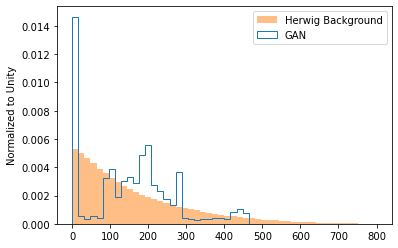

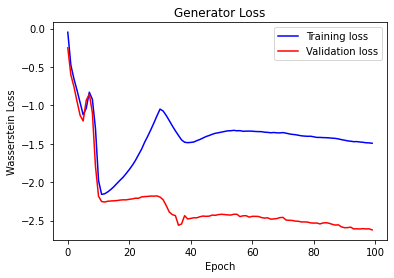

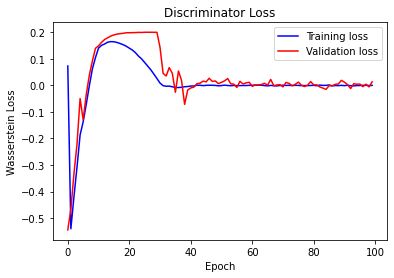

 11%|████████▍                                                                    | 110/1000 [43:15<5:53:04, 23.80s/it]


Epoch 110:

Generator training loss: -1.5492615685111186
Discriminator training loss: -0.0001300080111583862

Generator validation loss: -2.6850772245985564
Discriminator validation loss: 0.010203855767284666


 12%|█████████▏                                                                   | 120/1000 [47:13<5:49:06, 23.80s/it]


Epoch 120:

Generator training loss: -1.6260720784546898
Discriminator training loss: -0.0009294799194307058

Generator validation loss: -2.749992340314584
Discriminator validation loss: -0.0094024371285398


 13%|██████████                                                                   | 130/1000 [51:09<5:43:11, 23.67s/it]


Epoch 130:

Generator training loss: -1.666864539267587
Discriminator training loss: 0.0005583396612674022

Generator validation loss: -2.7929092508847595
Discriminator validation loss: -0.013463149948277488


 14%|██████████▊                                                                  | 140/1000 [55:07<5:40:17, 23.74s/it]


Epoch 140:

Generator training loss: -1.742315576050451
Discriminator training loss: -0.0014447051306465727

Generator validation loss: -2.8782951890445148
Discriminator validation loss: 0.02148816655638063


 15%|███████████▌                                                                 | 150/1000 [59:04<5:35:57, 23.72s/it]


Epoch 150:

Generator training loss: -1.7757939841252206
Discriminator training loss: 0.0007104194852347133

Generator validation loss: -2.901070979774975
Discriminator validation loss: -0.018388572305113603


 16%|████████████                                                               | 160/1000 [1:03:00<5:29:31, 23.54s/it]


Epoch 160:

Generator training loss: -1.8406763764027039
Discriminator training loss: -0.0012389257956336402

Generator validation loss: -2.974167830631381
Discriminator validation loss: 0.004090347564103512


 17%|████████████▊                                                              | 170/1000 [1:06:58<5:28:56, 23.78s/it]


Epoch 170:

Generator training loss: -1.9415967394419706
Discriminator training loss: 0.0010512287180843417

Generator validation loss: -3.083781047922666
Discriminator validation loss: 0.00776138898394582


 18%|█████████████▌                                                             | 180/1000 [1:10:55<5:24:36, 23.75s/it]


Epoch 180:

Generator training loss: -2.061419150216983
Discriminator training loss: 0.0013691326956021433

Generator validation loss: -3.1604027249773994
Discriminator validation loss: 0.0014617272721300309


 19%|██████████████▎                                                            | 190/1000 [1:14:52<5:18:54, 23.62s/it]


Epoch 190:

Generator training loss: -2.1001383268116602
Discriminator training loss: -0.00011796469326362286

Generator validation loss: -3.159480212164707
Discriminator validation loss: 0.0036297156710760215


 20%|██████████████▉                                                            | 199/1000 [1:18:25<5:16:13, 23.69s/it]


Epoch 200:

Generator training loss: -2.0919955429809343
Discriminator training loss: 0.0023692642913772178

Generator validation loss: -3.1226428874203416
Discriminator validation loss: -0.014323460306379692

Epoch 200:


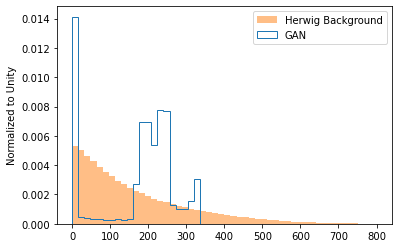

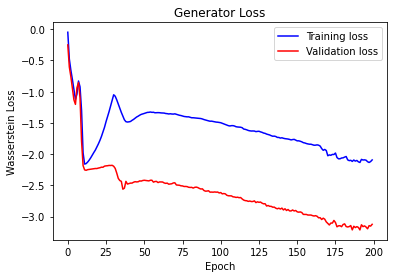

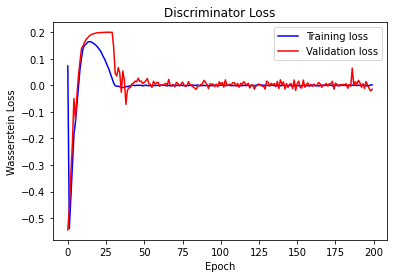

 21%|███████████████▊                                                           | 210/1000 [1:22:44<5:12:12, 23.71s/it]


Epoch 210:

Generator training loss: -2.0297177113144778
Discriminator training loss: 0.0005541411545310125

Generator validation loss: -3.1243650854611005
Discriminator validation loss: -0.00408198094833022


 22%|████████████████▌                                                          | 220/1000 [1:26:41<5:08:33, 23.74s/it]


Epoch 220:

Generator training loss: -1.9720045842759597
Discriminator training loss: -0.0002647611875918152

Generator validation loss: -3.042020073679627
Discriminator validation loss: 0.00854265141269487


 23%|█████████████████▎                                                         | 230/1000 [1:30:38<5:04:50, 23.75s/it]


Epoch 230:

Generator training loss: -1.985018802959411
Discriminator training loss: 0.00102607009956237

Generator validation loss: -3.060187848865009
Discriminator validation loss: -0.0016063817706112116


 24%|██████████████████                                                         | 240/1000 [1:34:35<4:59:50, 23.67s/it]


Epoch 240:

Generator training loss: -1.9735369524343418
Discriminator training loss: 0.0003903525183126416

Generator validation loss: -3.05437171459198
Discriminator validation loss: -0.02055255826405196


 25%|██████████████████▊                                                        | 250/1000 [1:38:31<4:56:11, 23.70s/it]


Epoch 250:

Generator training loss: -1.9831070641025168
Discriminator training loss: -0.0001290456391537991

Generator validation loss: -3.093291896288512
Discriminator validation loss: 0.018376330033967606


 26%|███████████████████▌                                                       | 260/1000 [1:42:28<4:52:41, 23.73s/it]


Epoch 260:

Generator training loss: -1.9755594585436942
Discriminator training loss: 0.0020602944831007537

Generator validation loss: -3.076011832620277
Discriminator validation loss: -0.002228248326200181


 27%|████████████████████▎                                                      | 270/1000 [1:46:25<4:48:25, 23.71s/it]


Epoch 270:

Generator training loss: -1.9962468157049085
Discriminator training loss: 0.0008328229598440178

Generator validation loss: -3.079076075163044
Discriminator validation loss: -0.004382357853575711


 28%|█████████████████████                                                      | 280/1000 [1:50:22<4:46:03, 23.84s/it]


Epoch 280:

Generator training loss: -2.0138777364147167
Discriminator training loss: -0.0003717698931564097

Generator validation loss: -3.0902150927997027
Discriminator validation loss: -0.006604570994016687


 29%|█████████████████████▊                                                     | 290/1000 [1:54:19<4:39:47, 23.64s/it]


Epoch 290:

Generator training loss: -2.0767157465382353
Discriminator training loss: -0.0008900921620806912

Generator validation loss: -3.1529210288016523
Discriminator validation loss: -0.0015067266173796493


 30%|██████████████████████▍                                                    | 299/1000 [1:57:53<4:38:09, 23.81s/it]


Epoch 300:

Generator training loss: -2.1025488366846177
Discriminator training loss: -0.0017924371554771986

Generator validation loss: -3.17705983900633
Discriminator validation loss: -0.015725365014017757

Epoch 300:


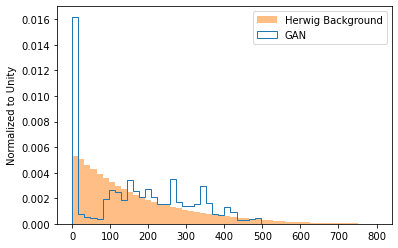

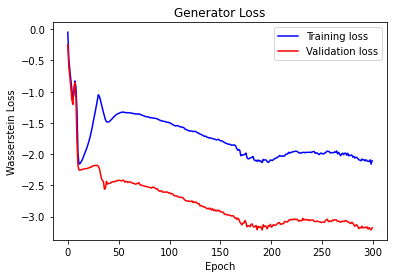

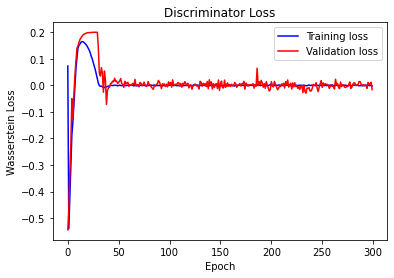

 31%|███████████████████████▎                                                   | 310/1000 [2:02:15<4:33:54, 23.82s/it]


Epoch 310:

Generator training loss: -2.191825263812894
Discriminator training loss: 0.0003018630400533095

Generator validation loss: -3.284946430902012
Discriminator validation loss: 0.029276715622085038


 32%|████████████████████████                                                   | 320/1000 [2:06:11<4:26:18, 23.50s/it]


Epoch 320:

Generator training loss: -2.1986247747322247
Discriminator training loss: -0.0008684666991959474

Generator validation loss: -3.278997429081651
Discriminator validation loss: 0.009624733983162246


 33%|████████████████████████▊                                                  | 330/1000 [2:10:08<4:25:08, 23.74s/it]


Epoch 330:

Generator training loss: -2.2715249038784884
Discriminator training loss: 0.0013053311804698173

Generator validation loss: -3.3826866628693755
Discriminator validation loss: -0.0030572808456751964


 34%|█████████████████████████▌                                                 | 340/1000 [2:14:05<4:20:22, 23.67s/it]


Epoch 340:

Generator training loss: -2.3384213463856223
Discriminator training loss: 0.00039638344532960597

Generator validation loss: -3.403654386762713
Discriminator validation loss: -0.0010733108371607427


 35%|██████████████████████████▎                                                | 350/1000 [2:18:01<4:16:47, 23.70s/it]


Epoch 350:

Generator training loss: -2.6121615585082214
Discriminator training loss: 0.001719128324904012

Generator validation loss: -3.5898743017775114
Discriminator validation loss: -0.00381545626807237


 36%|███████████████████████████                                                | 360/1000 [2:21:58<4:11:51, 23.61s/it]


Epoch 360:

Generator training loss: -2.692601018590354
Discriminator training loss: 0.0007983000266967494

Generator validation loss: -3.663974748283136
Discriminator validation loss: -0.038460991799556574


 37%|███████████████████████████▊                                               | 370/1000 [2:25:54<4:08:19, 23.65s/it]


Epoch 370:

Generator training loss: -2.753189012326829
Discriminator training loss: 0.00020944465985217915

Generator validation loss: -3.7556702181941173
Discriminator validation loss: 0.020516335429837468


 38%|████████████████████████████▌                                              | 380/1000 [2:29:51<4:04:30, 23.66s/it]


Epoch 380:

Generator training loss: -2.795266675818813
Discriminator training loss: 0.002139466585561775

Generator validation loss: -3.7724306182783156
Discriminator validation loss: 0.013147480260069315


 39%|█████████████████████████████▎                                             | 390/1000 [2:33:49<4:01:58, 23.80s/it]


Epoch 390:

Generator training loss: -2.6724509902990583
Discriminator training loss: -0.0018737179421492091

Generator validation loss: -3.7347699452619083
Discriminator validation loss: -0.01344919934896008


 40%|█████████████████████████████▉                                             | 399/1000 [2:37:22<3:56:12, 23.58s/it]


Epoch 400:

Generator training loss: -2.583263402428132
Discriminator training loss: -0.0001783506095367169

Generator validation loss: -3.6997111859868785
Discriminator validation loss: -0.000152103545334568

Epoch 400:


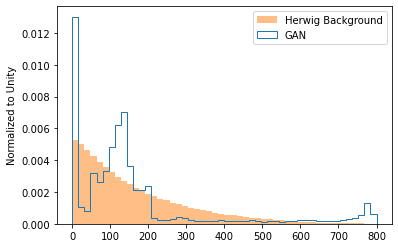

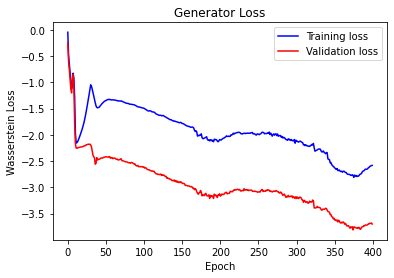

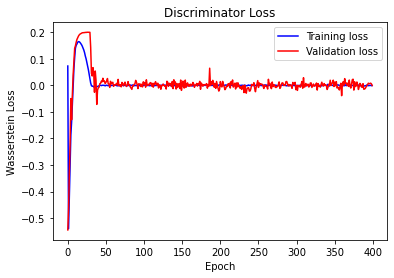

 41%|██████████████████████████████▋                                            | 410/1000 [2:41:42<3:52:02, 23.60s/it]


Epoch 410:

Generator training loss: -2.6954204345661434
Discriminator training loss: -1.0185466499272684e-05

Generator validation loss: -3.755853127260677
Discriminator validation loss: -0.02700647665855673


 42%|███████████████████████████████▌                                           | 420/1000 [2:45:40<3:48:49, 23.67s/it]


Epoch 420:

Generator training loss: -2.711735104928251
Discriminator training loss: 0.0008918450819304572

Generator validation loss: -3.8045271986820657
Discriminator validation loss: 0.022824424787016098


 43%|████████████████████████████████▎                                          | 430/1000 [2:49:36<3:44:59, 23.68s/it]


Epoch 430:

Generator training loss: -2.7094949868207423
Discriminator training loss: 0.0011060228461321428

Generator validation loss: -3.8029631239468933
Discriminator validation loss: 0.027263858702919277


 44%|█████████████████████████████████                                          | 440/1000 [2:53:32<3:40:18, 23.60s/it]


Epoch 440:

Generator training loss: -2.7525809749228056
Discriminator training loss: -0.0012978800382852619

Generator validation loss: -3.803038713384847
Discriminator validation loss: -0.006739655704193149


 45%|█████████████████████████████████▊                                         | 450/1000 [2:57:29<3:37:20, 23.71s/it]


Epoch 450:

Generator training loss: -2.8589544957452784
Discriminator training loss: -0.00018204517181516787

Generator validation loss: -3.9119607855062015
Discriminator validation loss: -0.02823221792856262


 46%|██████████████████████████████████▌                                        | 460/1000 [3:01:27<3:33:46, 23.75s/it]


Epoch 460:

Generator training loss: -2.9109090302811294
Discriminator training loss: 0.0006438029091083589

Generator validation loss: -3.965255480320727
Discriminator validation loss: -0.012137861419745844


 47%|███████████████████████████████████▎                                       | 470/1000 [3:05:23<3:28:35, 23.61s/it]


Epoch 470:

Generator training loss: -2.891196199779302
Discriminator training loss: 0.00046157257431948524

Generator validation loss: -3.9579077128504143
Discriminator validation loss: 0.008792078333812481


 48%|████████████████████████████████████                                       | 480/1000 [3:09:20<3:25:36, 23.72s/it]


Epoch 480:

Generator training loss: -2.943947200566693
Discriminator training loss: -0.000387539759926295

Generator validation loss: -3.9777341895416134
Discriminator validation loss: 0.0009842720942511644


 49%|████████████████████████████████████▊                                      | 490/1000 [3:13:16<3:20:56, 23.64s/it]


Epoch 490:

Generator training loss: -3.127246936162313
Discriminator training loss: 0.0005646378027986578

Generator validation loss: -4.153769921083919
Discriminator validation loss: 0.043394650103615935


 50%|█████████████████████████████████████▍                                     | 499/1000 [3:16:50<3:18:48, 23.81s/it]


Epoch 500:

Generator training loss: -3.155789613723755
Discriminator training loss: 0.0005176117898981283

Generator validation loss: -4.20047956998231
Discriminator validation loss: 0.01791305778277122

Epoch 500:


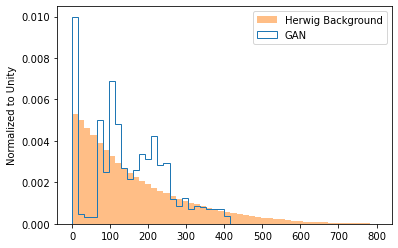

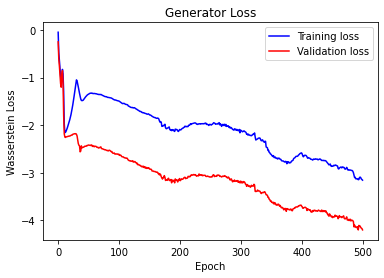

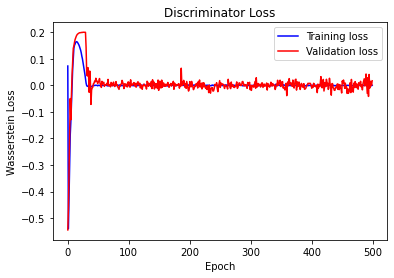

 51%|██████████████████████████████████████▎                                    | 510/1000 [3:21:10<3:12:41, 23.59s/it]


Epoch 510:

Generator training loss: -3.2411844935573515
Discriminator training loss: -3.1284123998956916e-05

Generator validation loss: -4.269332911147446
Discriminator validation loss: 0.02473403190859125


 52%|███████████████████████████████████████                                    | 520/1000 [3:25:06<3:08:17, 23.54s/it]


Epoch 520:

Generator training loss: -3.498195476219302
Discriminator training loss: -0.0012601375013959301

Generator validation loss: -4.506111066849505
Discriminator validation loss: 0.015372516252145793


 53%|███████████████████████████████████████▊                                   | 530/1000 [3:29:03<3:05:42, 23.71s/it]


Epoch 530:

Generator training loss: -3.6273414932313512
Discriminator training loss: 0.001387087722037616

Generator validation loss: -4.612681244240433
Discriminator validation loss: -0.0024099154362956453


 54%|████████████████████████████████████████▌                                  | 540/1000 [3:32:59<3:01:30, 23.68s/it]


Epoch 540:

Generator training loss: -3.7035378217697144
Discriminator training loss: -0.0011530245724360776

Generator validation loss: -4.691688215146299
Discriminator validation loss: -0.004160646213214753


 55%|█████████████████████████████████████████▎                                 | 550/1000 [3:36:57<2:58:01, 23.74s/it]


Epoch 550:

Generator training loss: -3.850787680982892
Discriminator training loss: 0.0009202904455666558

Generator validation loss: -4.795165484068824
Discriminator validation loss: -0.006889714680628309


 56%|██████████████████████████████████████████                                 | 560/1000 [3:40:54<2:53:58, 23.72s/it]


Epoch 560:

Generator training loss: -3.9223811587349315
Discriminator training loss: 0.0007269484133743032

Generator validation loss: -4.880355748973909
Discriminator validation loss: 0.01692873281300293


 57%|██████████████████████████████████████████▋                                | 570/1000 [3:44:51<2:50:05, 23.73s/it]


Epoch 570:

Generator training loss: -3.9854704903774576
Discriminator training loss: 0.0008289853712985015

Generator validation loss: -4.975602704970563
Discriminator validation loss: -0.011800267807228041


 58%|███████████████████████████████████████████▌                               | 580/1000 [3:48:48<2:46:10, 23.74s/it]


Epoch 580:

Generator training loss: -4.007179434507923
Discriminator training loss: 0.0012979873626312827

Generator validation loss: -4.997033787555382
Discriminator validation loss: 0.006477952707547181


 59%|████████████████████████████████████████████▎                              | 590/1000 [3:52:46<2:41:34, 23.65s/it]


Epoch 590:

Generator training loss: -4.073545076156575
Discriminator training loss: 0.0004984938390109284

Generator validation loss: -5.084343548680915
Discriminator validation loss: -0.004694376606136355


 60%|████████████████████████████████████████████▉                              | 599/1000 [3:56:20<2:38:49, 23.77s/it]


Epoch 600:

Generator training loss: -4.111628846066897
Discriminator training loss: 9.458720928034649e-05

Generator validation loss: -5.098356166823965
Discriminator validation loss: -0.021240135252124585

Epoch 600:


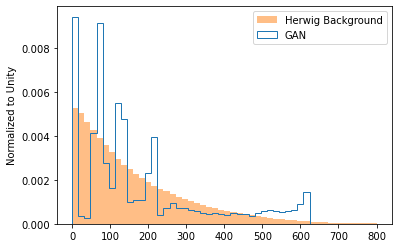

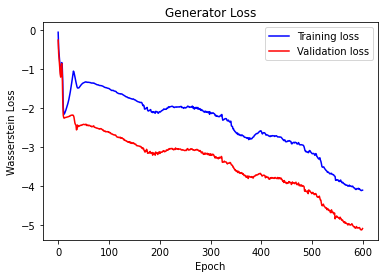

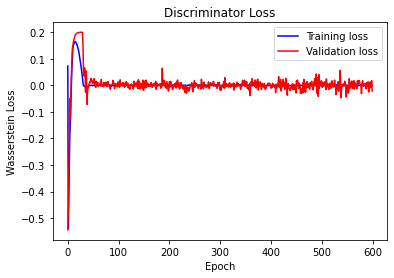

 61%|█████████████████████████████████████████████▊                             | 610/1000 [4:00:40<2:33:59, 23.69s/it]


Epoch 610:

Generator training loss: -4.2928443867000725
Discriminator training loss: -0.0006247147597088492

Generator validation loss: -5.29227156521844
Discriminator validation loss: -0.0003881311482831227


In [ ]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []
train(train_dataset, test_dataset, 1000, N_CRITIC)

## Results
Train for 4 features works pretty well and took 2:20 hrs for 1000 epos with a 1080

In [ ]:
z